## Environments -  Deterministic Rewards

In [144]:
import numpy as np
import random

class ContextualDeterministicEnv():
    
    ## Set class attributes such as context_dim and n_arms
    def __init__(self, context_dim_in, n_arms_in):
        self.context_dim = context_dim_in
        self.n_arms = n_arms_in
        self.reward = 1
      
    
    ## Generate a new context each time this method is called
    ## This is set as a state here in this class
    ## number of actions is the number of arms
    def get_context(self) -> np.ndarray:
        self.current_context = random.randint(0, self.n_arms-1)
        return np.array([self.current_context]).reshape(1, 1)
        #return(self.current_context)
    
    
    ## Set the logic for the correct action for a context
    ## Dictionary {(0,0): 0, (0,1): 2, (1,0): 3, (1,1): 4 }
    def set_context_action_mapping(self, context_action_mapping) -> None:
        self.context_action_mapping = context_action_mapping
        
        
    ## Given an action get the reward for that action for the current context
    ## Convert numpy array to tuple as tuple(map(tuple, arr))
    def get_reward(self, action: int, context: np.ndarray) -> float:
        if(self.context_action_mapping[str(context)] == action):
            return self.reward
        else:
            return 0

        
    def get_num_arms(self) -> int:
        return self.n_arms

    
    def get_context_dim(self) -> int:
        return self.context_dim

## Environment - Stochastic Rewards

In [148]:
import numpy as np
import random

class ContextualStochasticRewardsEnv():
    
    ## Set class attributes such as context_dim and n_arms
    def __init__(self, context_dim_in, n_arms_in, reward_probability):
        self.context_dim = context_dim_in
        self.n_arms = n_arms_in
        self.reward_probability = reward_probability
        self.reward = 1.0 / self.reward_probability
      
    
    ## Generate a new context each time this method is called
    ## This is set as a state here in this class
    ## number of actions is the number of arms
    def get_context(self) -> np.ndarray:
        self.current_context = random.randint(0, self.n_arms-1)
        return np.array([self.current_context]).reshape(1, 1)
        #return(self.current_context)
    
    
    ## Set the logic for the correct action for a context
    ## Dictionary {(0,0): 0, (0,1): 2, (1,0): 3, (1,1): 4 }
    def set_context_action_mapping(self, context_action_mapping) -> None:
        self.context_action_mapping = context_action_mapping
        
        
    ## Given an action get the reward for that action for the current context
    ## Convert numpy array to tuple as tuple(map(tuple, arr))
    def get_reward(self, action: int, context: np.ndarray) -> float:
        random_draw = random.uniform(0,1)
        if(random_draw > self.reward_probability):
            return 0
        else:
            if(self.context_action_mapping[str(context)] == action):
                return self.reward
            else:
                return 0

        
    def get_num_arms(self) -> int:
        return self.n_arms

    
    def get_context_dim(self) -> int:
        return self.context_dim

In [120]:
a = ContextualDeterministicEnv(1,3)
a.set_context_action_mapping({'[[0]]':0, '[[1]]':1, '[[2]]':2})

In [136]:
context_0 = a.get_context()
str(context_0)

'[[2]]'

In [127]:
a.get_reward(2, context_0)

1

In [107]:
a.context_action_mapping

{'[[0]]': 0, '[[1]]': 1}

In [155]:
a = ContextualStochasticRewardsEnv(1,3,0.5)
a.set_context_action_mapping({'[[0]]':0, '[[1]]':1, '[[2]]':2})
context_0 = a.get_context()
print(context_0)
a.get_reward(2, context_0)

[[2]]


2.0

## Epsilon Greedy Algorithm 

Inputs: Context vectors, rewards for each context vector when it is given an action, the correct action for a context, epsilon
Outputs: Reward is a click when a context is shown the correct action, maximize this reward. The plotted reward is the mean reward computed till time 't'. This is the sum of al rewards till time 't' divided by time 't'.

1. Select a context, here this is sampled randomly from a list of contexts. The context is the user visiting the website for example. It can also be read in from logged data about users visiting a website for example
2. Based on an action policy, which happens to be epsilon-greedy here, select an action for this context.
3. The action is selected with pobability (1 - epsilon) based on the results of a model that is continually updated. The action is selected randomly with probability epsilon.
4. Once an action is selected for a context, a reward is obtained. This reward is logged for each context and action.
5. For each arm or action, select the contexts that have seen this action. Also, select the rewards that this action produced for all the contexts selected. 
    a. For each arm or action, the context is the independent variable in the logistic regression equation. The reward is the dependent variable
    b. Solve the logistic regression model to produce new parameters for each arm or action.
6. Continue with step 1 till we have reached a desired number of context sample data.

#### Notes

The models trained are binary classifier with a 0 representing no click and a 1 representing a click. Each arm has a logistic regression model trained for it. Thus model predicts whether an arm would be clicked or not. You could get multiple arms being predicted as getting a click, we select an arm at random here. 

## Epsilon Greedy 

In [243]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.exceptions import NotFittedError


class EpsilonGreedy:

    def __init__(self, c_env: ContextualDeterministicEnv, epsilon: float, num_steps: int, training_freq: int):
        self.num_arms = c_env.get_num_arms()
        self.num_steps = num_steps
        self.epsilon = epsilon
        self.training_freq = training_freq
        self.classifiers = [LogisticRegression() for _ in range(self.num_arms)]
        context_dim = c_env.get_context_dim()
        self.context_data = np.zeros((num_steps, context_dim))
        self.rewards_data = np.full((num_steps, self.num_arms), -1, dtype=float)
        self.c_env = c_env
        
    
    ## Sample a context, generate an action based on an action policy such as epsilon greedy which in turn uses
    ## a model that was fit on data(1). Get a reward from this action. Use this reward to update the model by
    ## fitting for reward and context
    def simulate(self) -> np.ndarray:
        """Returns rewards per step"""

        rewards_history = np.zeros(self.num_steps)
        for step in range(self.num_steps):
            ## Generate a context
            context = self.c_env.get_context()
            ## Get the action for the context based on the policy, this is the epsilon greedy action policy here
            ## exploitation is based on the model that is fit in an online fashion
            action = self.action_policy(context)
            ## Get the reward given the action that was selected for the context
            reward = self.c_env.get_reward(action, context)
            rewards_history[step] = reward
            self.save_step(context, action, reward, step)
            if step % self.training_freq == 0:
                self.fit(step)
        
        return rewards_history

    
    def fit_classifier(self, contexts: np.ndarray, rewards: np.ndarray, arm: int) -> None:
        arm_rewards = rewards[:, arm]
        # get the index of the rewards that the arm saw
        index = np.argwhere(arm_rewards != -1)
        index = index.flatten()
        arm_rewards = arm_rewards[index]
        # test if the arm saw at least one example of 
        # each class
        if len(np.unique(arm_rewards)) == 2:
            arm_contexts = contexts[index]
            self.classifiers[arm].fit(arm_contexts, arm_rewards)

            
    def fit(self, step: int) -> None:
        step += 1
        contexts_so_far = self.context_data[:step]
        rewards_so_far = self.rewards_data[:step]
        for arm_index in range(self.num_arms):
            self.fit_classifier(contexts_so_far, rewards_so_far, arm_index)
            
            
    def greedy_action(self, context: np.ndarray) -> int:
        rewards = np.zeros(len(self.classifiers))
        for index, classifier in enumerate(self.classifiers):
            try:
                context = context.reshape(1, -1)
                action_score = classifier.predict_proba(context)[0][1]
                #action_score = classifier.predict(context)
            except NotFittedError as e:
                a = 3.0/self.num_arms
                action_score = np.random.beta(a, 4)
            rewards[index] = action_score
        
        max_rewards = max(rewards)
        best_actions = np.argwhere(rewards == max_rewards)
        best_actions = best_actions.flatten()
        if len(best_actions) > 1:
            return np.random.choice(best_actions)
        else:
            return(best_actions)
    
    
    def action_policy(self, context: np.ndarray) -> int:
        coin = random.uniform(0, 1)
        if coin > self.epsilon:
            action = self.greedy_action(context)
        else:
            action = random.randint(0, self.num_arms-1)
        return action

    
    def save_step(self, context: np.ndarray, action: int, reward: float, step: int) -> None:
        self.context_data[step] = context
        self.rewards_data[step, action] = reward


### Run Deterministic Rewards

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:59<00:00,  2.40s/it]


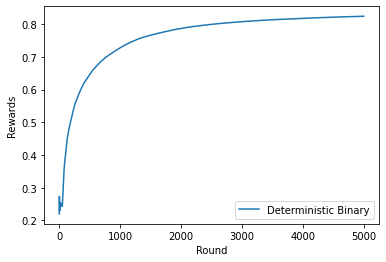

In [251]:
from matplotlib import pyplot as plt 

num_steps = 5000
num_iterations = 100
n_arms = 4

environment = ContextualDeterministicEnv(context_dim_in=1, n_arms_in=n_arms)
#environment.set_context_action_mapping({'[[0]]':0, '[[1]]':1})
environment.set_context_action_mapping({'[[0]]':0, '[[1]]':1, '[[2]]':2, '[[3]]':3})
envs = [environment]

pbar = tqdm(total=len(envs)*num_iterations)
rewards = np.zeros((num_steps, 3, num_iterations))
for iteration in range(num_iterations):
    bandits = [EpsilonGreedy(x, 0.2, num_steps, 50) for x in envs]
    for bandit_index, bandit in enumerate(bandits):
        rewards[:, bandit_index, iteration] = bandit.simulate()
        pbar.update(1)
pbar.close()

def get_mean_rewards(rewards: np.ndarray, bandit_index: int) -> np.ndarray:
    bandit_rewards = rewards[:, bandit_index, :]
    bandit_rewards = np.mean(bandit_rewards, axis=1)
    mean_rewards = np.zeros_like(bandit_rewards)
    for index in range(len(bandit_rewards)):
        mean_rewards[index] = np.mean(bandit_rewards[:index+1])
    return mean_rewards

mean_rewards = [get_mean_rewards(rewards, x) for x in range(len(bandits))]

filename = f"EpsilonGreedy_Deterministic_{n_arms}"
np.save(file=filename, arr=mean_rewards)

labels = ["Deterministic Binary"]
for x, label in zip(mean_rewards, labels):
    plt.plot(x, label=label)
plt.ylabel("Rewards")
plt.xlabel("Round")
plt.legend()

### Run Stochastic Rewards (Simplified code for simulation)


  1%|█                                                                                                              | 1/100 [22:26:17<2221:22:28, 80777.26s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [03:26<00:02,  2.05s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:28<00:00,  2.09s/it]

True


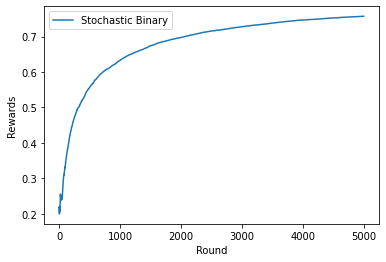

In [250]:
from matplotlib import pyplot as plt 

num_steps = 5000
num_iterations = 100
n_arms = 4

environment = ContextualStochasticRewardsEnv(context_dim_in=1, n_arms_in=n_arms, reward_probability=0.5)
#environment.set_context_action_mapping({'[[0]]':0, '[[1]]':1})
environment.set_context_action_mapping({'[[0]]':0, '[[1]]':1, '[[2]]':2, '[[3]]':3})
envs = [environment]

## rewards is num_steps x bandit_index x num_iterations 
pbar = tqdm(total=len(envs)*num_iterations)
rewards = np.zeros((num_steps, num_iterations))
for iteration in range(num_iterations):
    bandits = EpsilonGreedy(environment, 0.2, num_steps, 50)
    rewards[:, iteration] = bandits.simulate()
    pbar.update(1)
pbar.close()

def get_mean_rewards(rewards: np.ndarray) -> np.ndarray:
    bandit_rewards = rewards[:, :]
    bandit_rewards = np.mean(bandit_rewards, axis=1)
    cumulative_rewards = np.zeros_like(bandit_rewards)
    mean_rewards = np.zeros_like(bandit_rewards)
    for index in range(len(bandit_rewards)):
        mean_rewards[index] = np.mean(bandit_rewards[:index+1])
       
    for index, reward in enumerate(bandit_rewards):
        if(index == 0):
            cumulative_rewards[index] = reward
        else:
            cumulative_rewards[index] = (cumulative_rewards[index - 1]*(index) + reward) / (index + 1)
        
    return mean_rewards, cumulative_rewards

mean_rewards, cumulative_rewards = get_mean_rewards(rewards)
print(np.allclose(mean_rewards, cumulative_rewards))

filename = f"EpsilonGreedy_Stochastic_{n_arms}"
np.save(file=filename, arr=mean_rewards)

labels = ["Stochastic Binary"]
plt.plot(mean_rewards, label=labels[0])
plt.ylabel("Rewards")
plt.xlabel("Round")
plt.legend()

### Ignore the code below

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s]


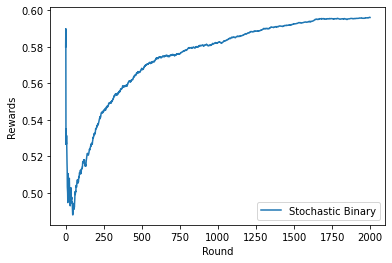

In [221]:
from matplotlib import pyplot as plt 

num_steps = 2000
num_iterations = 100

environment = ContextualStochasticRewardsEnv(context_dim_in=1, n_arms_in=2, reward_probability=0.5)
environment.set_context_action_mapping({'[[0]]':0, '[[1]]':1})
#environment.set_context_action_mapping({'[[0]]':0, '[[1]]':1, '[[2]]':2, '[[3]]':3})
envs = [environment]

pbar = tqdm(total=len(envs)*num_iterations)
rewards = np.zeros((num_steps, 3, num_iterations))
for iteration in range(num_iterations):
    bandits = [EpsilonGreedy(x, 0.2, num_steps, 50) for x in envs]
    for bandit_index, bandit in enumerate(bandits):
        rewards[:, bandit_index, iteration] = bandit.simulate()
        pbar.update(1)
pbar.close()

def get_mean_rewards(rewards: np.ndarray, bandit_index: int) -> np.ndarray:
    bandit_rewards = rewards[:, bandit_index, :]
    bandit_rewards = np.mean(bandit_rewards, axis=1)
    mean_rewards = np.zeros_like(bandit_rewards)
    for index in range(len(bandit_rewards)):
        mean_rewards[index] = np.mean(bandit_rewards[:index+1])
    return mean_rewards

mean_rewards = [get_mean_rewards(rewards, x) for x in range(len(bandits))]

labels = ["Stochastic Binary"]
for x, label in zip(mean_rewards, labels):
    plt.plot(x, label=label)
plt.ylabel("Rewards")
plt.xlabel("Round")
plt.legend()

 ...]

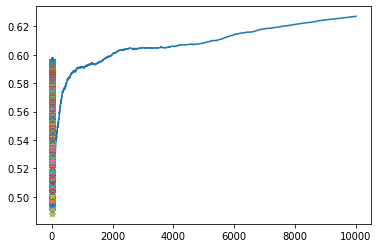

In [222]:
rewards_array = []
for index in range(len(bandit_rewards)):
       rewards_array.append(np.mean(bandit_rewards[:index+1]))
        
plt.plot(cumulative_rewards)
plt.plot(mean_rewards, '*')